In [1]:
import tensorflow as tf

In [2]:
use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)


# if use_tpu:
#   # Create model on TPU:
#   with strategy.scope():
#     model = create_model1()
#     optimizer = tf.keras.optimizers.Adam()
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# else:
#   model = create_model1()
#   model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# **ECS 7001 - NN & NNLP**

## **Lab 2: LSTM for Text Classification**

<br>

**January 31st**

In Lab 2, you trained word embeddings by casting the unsupervised learning problem as a binary classification problem (i.e. using the skip-gram model). This week, you will build an LSTM model to classify movie reviews as either positive or negative. After training, you will extract the word embeddings learned by the model.



### **0. Prepare the environment**

Open Google Colab or activate the virtual environment you’ve created

### **1. Getting the Dataset**

You will be using the imdb dataset from Lab 0. This is a dataset of 25,000 movie reviews from IMDB, labeled by sentiment - positive (1) or negative (0). 
<br>

The reviews have been preprocessed, and each review is encoded as a list of word indices. Last week, you assigned the indices to the word randomly (or in order of their first appearance in the corpus) but in this preprocessed corpus, the words are indexed by overall frequency in the dataset, such that a word with index 3 occurs more frequently than a word with index 10.
<br>

In the following blocks of code in this section, we will load and visualize the data.


In [3]:
from tensorflow.keras import datasets

imdb = datasets.imdb

In [4]:
%%capture

# we'll use the most frequent 10000 words in the vocabulary
VOCAB_SIZE = 10000

# 0 is reserved for ‘<PAD>’, 1 for ‘<START>’ and 2 for ‘<UNK>’ i.e. words not in vocabulary
# the documentation says index_from = 3 but actually uses the value as an offset. The words
# in the dictionary are indexed from 1 by default so, saying index_from=3 means any actual
# words would start from 4 (1+3) and index 3 will be left unused. We use index_from=offset=2 to avoid this
# If you want to explore this further, you may look up the source_code for load_data here
# https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/datasets/imdb.py#L31-L162
OFFSET = 2

# for more information on the load_data method, type(help(load_data))
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=VOCAB_SIZE, index_from=OFFSET)

***Sanity Check***

Each instance in the training data is a list of word indices representing the words in a movie review.

Each label is 1 if that review is positive, else 0.

In [ ]:
print('Sample review:', train_data[0])

Sample review: [1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 2, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 2, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 2, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 5243, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 2, 7, 3, 106, 116, 5951, 14, 255, 3, 2, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 2, 1028, 12, 103, 87, 3, 380, 14, 296, 97, 31, 2070, 55, 25, 140, 5, 193, 7485, 17, 3, 225, 21, 20, 133, 475, 25, 479, 4, 143, 29, 5534, 17, 50, 35, 27, 223, 91, 24, 103, 3, 225, 64, 15, 37, 1333, 87, 11, 15, 282, 4, 15, 4471, 112, 102, 31, 14, 15, 5344, 18, 177, 31]


In [ ]:
print('\n Sample label:', train_labels[0])


 Sample label: 1


### **2. Readying the Inputs for the LSTM**

The movie reviews are of different lengths. The standard way of dealing with varying length inputs is to ***pad*** or ***truncate*** each sentence to a fixed length (which we choose heuristically). 

Keras provides a way to do this.  In this section, you will use the keras.preprocessing.sequence method <pad_sequences> handle padding and truncating.

**Hints**

*  help(pad_sequences) will give you more information about how this works.
*  You can experiment with 'pre' vs 'post' padding/truncating. In practice, 'pre' padding is more effective for our purposes; can you hypothesize about why this is?
*  Since we have reserved 0 for \<PAD\>, your pad value should be set to 0.
*  The maximum length has been specified below as MAX_LENGTH.

In [5]:
# from keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import pad_sequences


MAX_LENGTH = 500

# YOUR CODE GOES HERE
padded_train_data = pad_sequences(train_data, maxlen=MAX_LENGTH)
padded_test_data = pad_sequences(test_data, maxlen=MAX_LENGTH)

***Sanity Check***

For the first training example, print its length and the padded sequence to see the effect of your padding process. 

PS: Pre-padding was used for the output you see below.

In [ ]:
print('Length of sample train_data before preprocessing:', len(train_data[0]))
print('Length of sample train_data after preprocessing:', len(padded_train_data[0]))
print('Sample train data:', padded_train_data[0])

Length of sample train_data before preprocessing: 218
Length of sample train_data after preprocessing: 500
Sample train data: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  

### **3. Building the Model**

In this section, you will use the keras Model API to build a classification model.

*   The first step is to tell the model what sort of input to expect using the keras \<Input\> layer 
*   The second step is to add an embedding layer like we did last week. 
This embedding layer creates a lookup table of the form {word:embedding} for each of the unique words in our corpus. Use EMBED_SIZE = 100 (i.e each word is represented by a 100D vector such that each movie review is 500 X 100 in dimension.  Don't forget to set mask_zero=True since we are using 0 index as out padding.
*  The third step is to add an LSTM with 100 units. By leaving 'return_sequences' as False, the output of this model will be the output of the final time step of the LSTM. https://keras.io/api/layers/recurrent_layers/lstm/ 
*  The final layer of the model is a fully connected (Dense) layer. Can you figure out what activation function would be appropriate for this layer given the binary nature of the task?
*  The model should be compiled with a 'binary_crossentropy' loss function, an 'adam' optimizer. We also want to visualize the model accuracy during training so the 'metrics' parameter of the compile method should be set to ['accuracy'].

In [6]:
from keras.layers import Input, Embedding, Dense, LSTM
from keras.models import Model
from keras import Sequential
import tensorflow as tf

EMBED_SIZE = 100
# YOUR CODE GOES HERE

def create_model1():
  return Sequential([
    Input((MAX_LENGTH,), dtype="int32", name="input_layer"),
    Embedding(VOCAB_SIZE, EMBED_SIZE, mask_zero=True),
    LSTM(100),
    Dense(1, activation="sigmoid")
  ])



In [ ]:
use_tpu = True
if use_tpu:
  # Create model on TPU:
  with strategy.scope():
    model1 = create_model1()
    optimizer1 = tf.keras.optimizers.Adam()
    model1.compile(optimizer=optimizer1, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model1 = create_model1()
  model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

***Sanity Check***

Print the model summary and visualize it using vis_utils.

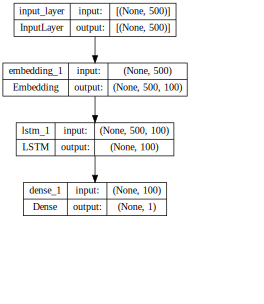

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model1, show_shapes=True, show_layer_names=True, dpi=100).create(prog='dot', format='svg'))  


### **4. Training the Model**

A model can memorize the training data (this is called 'overfitting' and when it does so, it's training accuracy can continue to go up but it's accuracy on previously unseen (i.e. non-training) examples can be very poor. To ensure that this doesn't happen, researchers often intermittently check the performance of a model being trained on a held back dataset called the ***validation dataset***. This way, 'early stopping' or 'random search' can be used to select the model that will generalize best to unseen data. 
<br>


In this lab, you will just plot training accuracy against validation accuracy to monitor the progress of your model. And, using the plot, you will theorize about what the optimal stopping point for your model should have been.


**Step 1: Getting a validation dataset**

Before we begin training, you will split the padded training data into training and validation data. To avoid losing too much training data, use 2000 samples (i.e 8%) for validation and the other 23000 for training.

We will do this using the sklearn train_test_split function. 

In [7]:
from sklearn.model_selection import train_test_split

train_x, validation_x, train_y, validation_y = train_test_split(padded_train_data, train_labels, test_size=0.08) 

Alternatively, we could have chosen to set validation_size=0.08 in our model.fit() function below instead of passing in a separate validation dataset.

**Step 2: Training the model**

We will use model.fit() to train the model. We will set our batch_size to 1000, which means the model will train int(23000/1000) batches each epoch. In other words, at each epoch the model will train 23 batches, each one consisting of 1000 movie reviews.

In [ ]:
history1 = model1.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 11s 250ms/step - loss: 0.6405 - accuracy: 0.6569 - val_loss: 0.4688 - val_accuracy: 0.7910
Epoch 2/6
23/23 [==============================] - 2s 69ms/step - loss: 0.4041 - accuracy: 0.8390 - val_loss: 0.3466 - val_accuracy: 0.8435
Epoch 3/6
23/23 [==============================] - 2s 69ms/step - loss: 0.2640 - accuracy: 0.9000 - val_loss: 0.2787 - val_accuracy: 0.8815
Epoch 4/6
23/23 [==============================] - 2s 89ms/step - loss: 0.1932 - accuracy: 0.9304 - val_loss: 0.2631 - val_accuracy: 0.8950
Epoch 5/6
23/23 [==============================] - 2s 77ms/step - loss: 0.1610 - accuracy: 0.9469 - val_loss: 0.2634 - val_accuracy: 0.8955
Epoch 6/6
23/23 [==============================] - 2s 78ms/step - loss: 0.1318 - accuracy: 0.9571 - val_loss: 0.2786 - val_accuracy: 0.8965


**Step 3: Visualize the model plot**

In [ ]:
pip install plot_keras_history

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9472 sha256=67a1a57fc9e75be22f78e8b78291fbcb36ab69aa348feabf3a2e5107e2636d68
  Stored in directory: /root/.cache/pip/wheels/97/a5/76/35ae3e15da1ce4530de8591b0bcd7716f6d6752a4808f01c04
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320514 sha256=d33f1b84cdcc2297aa1fe437e997272d683f47d2aa5ef30b75e87c1ebbc726a7
  Stored in directory: /root/.cache/pip/wheels/a3/5f/ba/ddd191edb6c749a63cffabd28714d5600b5b58014daf7434a8
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl siz

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

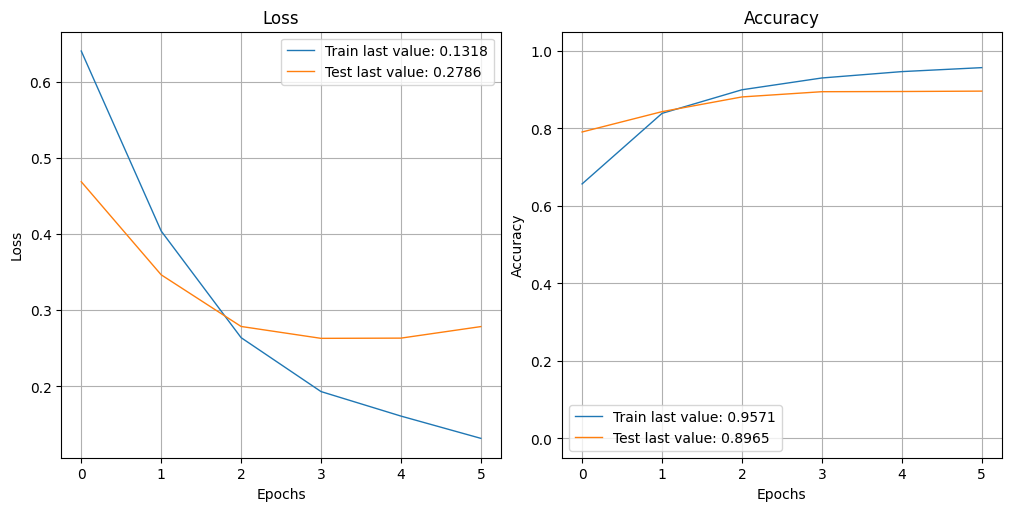

In [ ]:
plot_history(history1.history, path="standard.png")
plt.show()

**Based on the accuracy plot, what do you think the optimal stopping point for your model should
have been?**

### **5. Evaluating the Model on the Test Data**

Evaluate the model on the padded test data using the code in the following cell block.

In [ ]:
# YOUR CODE TO EVALUATE THE MODEL ON TEST DATA GOES HERE
results1 = model1.evaluate(padded_test_data, test_labels)
print('test_loss:', results1[0], 'test_accuracy:', results1[1])

782/782 [==============================] - 27s 30ms/step - loss: 0.3362 - accuracy: 0.8698
test_loss: 0.3361652195453644 test_accuracy: 0.8697999715805054


###**6. Extracting the Word Embeddings**

Extract the word embeddings from the embedding layer model like we did in the last lab. 

**Hints**

*  You can use model.get_layer(layer_name).get_weights()[0] or model.layers[layer_number].get_weights()[0].  The layer number indicates the order in which the layers were added to the model.

*  If you didn't explicitly name your layers, you can check layer names and numbers about the order from model.summary() or by calling model.layers

In [ ]:
# YOUR CODE GOES HERE
word_embeddings = model1.get_layer("embedding").get_weights()[0]
word_embeddings

array([[ 3.4749378e-02, -2.2928989e-02, -4.2274475e-02, ...,
        -4.3718927e-03,  1.0064624e-02,  4.5535397e-02],
       [ 2.3769684e-02,  5.8057359e-03, -2.6436143e-02, ...,
        -4.2127468e-02, -4.8266929e-03, -7.4862414e-03],
       [ 1.2521219e-02, -4.7143720e-02, -3.0311683e-02, ...,
        -2.0626618e-02,  3.4024056e-02,  4.1290544e-02],
       ...,
       [-3.9206073e-02, -3.3671297e-02, -2.2987328e-02, ...,
        -2.8887803e-02, -5.3392280e-02, -3.4171395e-02],
       [-9.5277885e-04, -3.0669689e-02, -5.2893320e-03, ...,
        -1.2355002e-03, -5.2379837e-06, -1.4340783e-02],
       [-3.5420250e-02,  2.9436966e-02, -9.1634635e-03, ...,
        -4.7970964e-03, -4.5394264e-02,  2.3518251e-02]], dtype=float32)

***Sanity Check***

Print the shape of the word embeddings using the line of code below. It should return (VOCAB_SIZE, EMBED_SIZE)

In [ ]:
print('Shape of word_embeddings:', word_embeddings.shape)

Shape of word_embeddings: (10000, 100)


In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


###**7. Visualizing the Reviews**

In this section, we will view the effects of padding the dataset. 

As mentioned before, Keras already preprocessed the corpus. In this preprocessed corpus, all the words have already been mapped to indices and were assigned these numbers in order of their frequency such that index 2 is the 2nd most frequent word in the dataset, and so on. However, when we loaded our training dataset, we reserved the first 3 indices - 0, 1, 2 - for \<PAD\>, \<START\> and \<UNK\>. Additionally, we limited our vocabulary to only the top 10000 most frequent words (9997 if you exclude the padding). We will now visualize what a movie review will look like with these changes




**Step 1: Create a word2idx dictionary**

Create the word2idx dictionary using the following lines of code.

In [ ]:
# in this dictionary, the words start from 1, 0 is reserved for padding but 
# <start> and <unknown> are not accounted for.
word_indices = imdb.get_word_index()

# so we shift each original word two places to make room for the two new tokens
offset = 2
word2idx = {k:(v+offset) for k,v in word_indices.items() if v < 9998}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2

1641221/1641221 [==============================] - 0s 0us/step



**Step 2: Create a the idx2word dictionary**

In [ ]:
# YOUR CODE GOES HERE

idx2word = {v:k for k,v in word2idx.items()}


**Step 3: Visualize sample review**

View a sample review text using the lines of code below:

In [ ]:
print(' '.join(idx2word[idx] for idx in train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

###**8. Visualizing the Word_Embeddings**

Visualize the word embeddings for 10 of the words using pandas DataFrame like we did in lab 3

In [ ]:
from pandas import DataFrame

DataFrame(word_embeddings, index=idx2word.values()).head(10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
woods,0.034749,-0.022929,-0.042274,0.003660,0.012328,0.019674,0.047157,0.030400,0.039966,0.005881,...,-0.025695,-0.020659,-0.029948,-0.021821,-0.003663,-0.001473,-0.038691,-0.004372,0.010065,0.045535
hanging,0.023770,0.005806,-0.026436,0.023907,-0.036522,-0.003042,0.006303,0.054684,0.021125,-0.000722,...,-0.001673,0.021840,0.005051,-0.039812,-0.014943,-0.031275,-0.044489,-0.042127,-0.004827,-0.007486
woody,0.012521,-0.047144,-0.030312,0.001971,-0.032417,0.008225,-0.027092,-0.019926,-0.009127,0.031912,...,0.002320,-0.051157,-0.002887,-0.041049,-0.020325,0.026693,0.051277,-0.020627,0.034024,0.041291
arranged,0.056459,0.052256,0.010988,0.041696,0.042100,-0.034009,0.054902,-0.020743,-0.012765,-0.016781,...,-0.042161,0.016000,-0.027051,0.008761,0.022420,-0.030188,-0.010200,0.051167,0.007491,0.048922
bringing,0.037957,0.017603,-0.037762,0.003273,-0.046980,-0.029365,-0.018095,0.026762,-0.019261,0.013654,...,0.036962,-0.037561,-0.001162,0.003658,0.032474,-0.008875,-0.039150,-0.004123,-0.017973,0.029953
wooden,0.034470,-0.021360,0.003335,0.041142,-0.032598,0.026591,0.040554,-0.046954,-0.032404,0.025215,...,0.000053,0.031198,0.041692,0.027852,0.034170,0.008012,-0.023703,0.047946,0.005021,-0.038742
errors,0.043822,0.024764,0.047095,-0.036585,-0.034633,-0.013739,0.037724,-0.042581,-0.006961,-0.019361,...,0.043611,0.040472,-0.036316,0.026268,-0.022406,-0.001418,-0.038634,0.002916,0.026779,0.034794
dialogs,0.008102,-0.046629,-0.037880,-0.024437,0.014995,0.050349,0.022416,-0.043939,-0.011451,0.002020,...,-0.017627,0.009910,0.038459,0.029377,0.031789,-0.049039,-0.044007,-0.010963,-0.004486,0.017865
kids,-0.012254,-0.008369,-0.035314,0.030103,-0.018072,-0.021425,0.023406,0.050894,0.006287,-0.021122,...,-0.008116,-0.005464,-0.031098,-0.039549,0.030379,-0.015896,0.032091,-0.043142,0.014615,0.050342
uplifting,0.030923,0.008830,0.025629,0.024759,-0.010428,0.028655,0.034355,0.014114,0.003080,0.043952,...,0.005992,-0.012695,0.010913,-0.028248,-0.024437,0.012366,-0.035219,0.016773,0.006153,-0.000062


###**9. Plot your Word Embeddings using t-SNE**


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


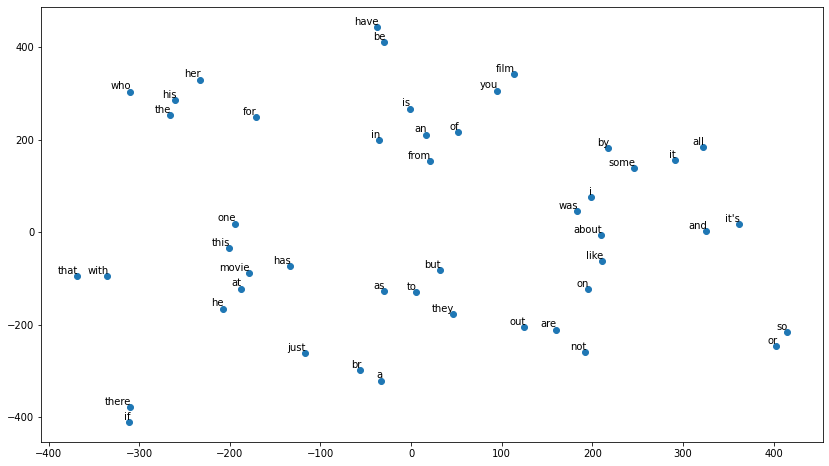

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50

# don't plot the special tokens
start = 3
T = tsne.fit_transform(word_embeddings[start:plot_only, :])
labels = [idx2word[i] for i in range(start, plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        


###**10. Questions**

1. Create a new model that is a copy of the model step 3. To this new model,add two dropout layers, one between the embedding layer and the LSTM layer and another between the LSTM layer and the output layer. Repeat steps 4 and 5 for this model. What do you observe?

2. Experiment with training the model with batch sizes of 1, 32, len(train_data). What do you observe?

3. (optional) Can you retrain with a Bidirectional LSTM instead of an LSTM? What do you observe about the Bi-LSTM model?


Question 1

In [ ]:
from keras.layers import Dropout

def create_model2():
  return Sequential([
    Input((MAX_LENGTH,), dtype="int32", name="input_layer"),
    Embedding(VOCAB_SIZE, EMBED_SIZE, mask_zero=True),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
  ])

In [ ]:
use_tpu = True
if use_tpu:

  # Create model on TPU:
  with strategy.scope():
    model2 = create_model2()
    optimizer2 = tf.keras.optimizers.Adam()
    model2.compile(optimizer=optimizer2, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model2 = create_model2()
  model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 100)          1000000   
                                                                 
 dropout (Dropout)           (None, 500, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


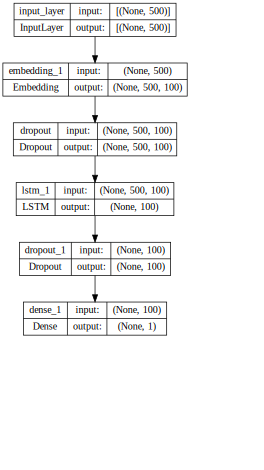

In [ ]:
SVG(vis_utils.model_to_dot(model2, show_shapes=True, show_layer_names=True, dpi=100).create(prog='dot', format='svg'))

In [ ]:
history2 = model2.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 11s 205ms/step - loss: 0.6444 - accuracy: 0.6417 - val_loss: 0.5111 - val_accuracy: 0.8065
Epoch 2/6
23/23 [==============================] - 2s 71ms/step - loss: 0.4095 - accuracy: 0.8387 - val_loss: 0.3138 - val_accuracy: 0.8750
Epoch 3/6
23/23 [==============================] - 2s 74ms/step - loss: 0.2691 - accuracy: 0.8965 - val_loss: 0.2591 - val_accuracy: 0.8995
Epoch 4/6
23/23 [==============================] - 2s 76ms/step - loss: 0.2070 - accuracy: 0.9245 - val_loss: 0.2799 - val_accuracy: 0.8990
Epoch 5/6
23/23 [==============================] - 2s 82ms/step - loss: 0.1743 - accuracy: 0.9396 - val_loss: 0.2568 - val_accuracy: 0.8985
Epoch 6/6
23/23 [==============================] - 2s 70ms/step - loss: 0.1416 - accuracy: 0.9523 - val_loss: 0.2766 - val_accuracy: 0.8980


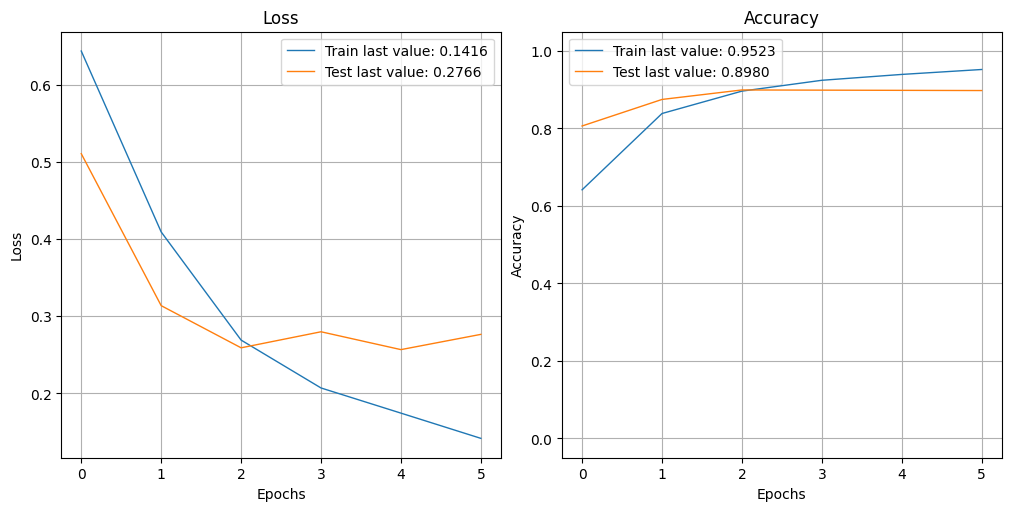

In [ ]:
plot_history(history2.history, path="standard2.png")
plt.show()

In [ ]:
results2 = model2.evaluate(padded_test_data, test_labels)
print('test_loss:', results2[0], 'test_accuracy:', results2[1])

782/782 [==============================] - 21s 23ms/step - loss: 0.3483 - accuracy: 0.8703
test_loss: 0.3482823073863983 test_accuracy: 0.8703200221061707


Question 2

In [ ]:
def create_model3():
  return Sequential([
    Input((MAX_LENGTH,), dtype="int32", name="input_layer"),
    Embedding(VOCAB_SIZE, EMBED_SIZE, mask_zero=True),
    LSTM(100),
    Dense(1, activation="sigmoid")
  ])

In [ ]:
use_tpu = True
if use_tpu:

  # Create model on TPU:
  with strategy.scope():
    model3 = create_model3()
    optimizer3 = tf.keras.optimizers.Adam()
    model3.compile(optimizer=optimizer3, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model3 = create_model3()
  model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

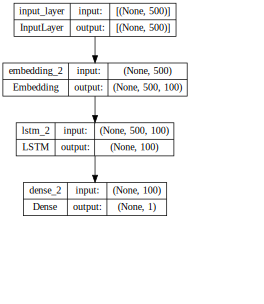

In [ ]:
SVG(vis_utils.model_to_dot(model3, show_shapes=True, show_layer_names=True, dpi=100).create(prog='dot', format='svg'))

In [ ]:
history3 = model3.fit(train_x, train_y, epochs=6, batch_size=1, validation_data=(validation_x, validation_y))

Epoch 1/6
23000/23000 [==============================] - 1302s 56ms/step - loss: 0.3814 - accuracy: 0.8153 - val_loss: 0.2402 - val_accuracy: 0.9050
Epoch 2/6
23000/23000 [==============================] - 1287s 56ms/step - loss: 0.1912 - accuracy: 0.9282 - val_loss: 0.2393 - val_accuracy: 0.9035
Epoch 3/6
23000/23000 [==============================] - 1286s 56ms/step - loss: 0.1311 - accuracy: 0.9536 - val_loss: 0.2463 - val_accuracy: 0.9090
Epoch 4/6
23000/23000 [==============================] - 1289s 56ms/step - loss: 0.0885 - accuracy: 0.9699 - val_loss: 0.3258 - val_accuracy: 0.9050
Epoch 5/6
23000/23000 [==============================] - 1289s 56ms/step - loss: 0.0557 - accuracy: 0.9825 - val_loss: 0.4003 - val_accuracy: 0.9040
Epoch 6/6
23000/23000 [==============================] - 1292s 56ms/step - loss: 0.0341 - accuracy: 0.9895 - val_loss: 0.4146 - val_accuracy: 0.8915


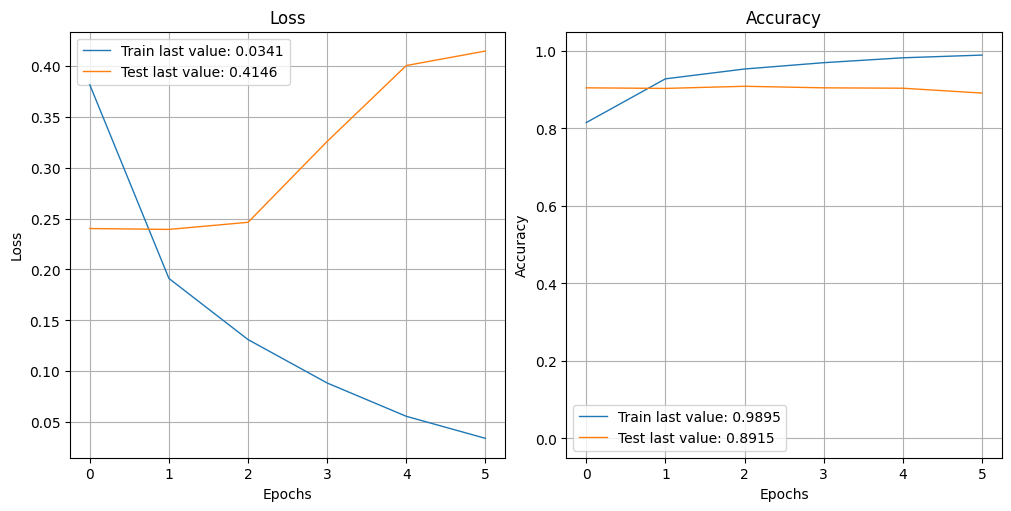

In [ ]:
plot_history(history3.history, path="standard3.png")
plt.show()

In [ ]:
results3 = model3.evaluate(padded_test_data, test_labels)
print('test_loss:', results3[0], 'test_accuracy:', results3[1])

782/782 [==============================] - 17s 20ms/step - loss: 0.4525 - accuracy: 0.8732
test_loss: 0.45245346426963806 test_accuracy: 0.873199999332428


In [ ]:
def create_model4():
  return Sequential([
    Input((MAX_LENGTH,), dtype="int32", name="input_layer"),
    Embedding(VOCAB_SIZE, EMBED_SIZE, mask_zero=True),
    LSTM(100),
    Dense(1, activation="sigmoid")
  ])

In [ ]:
use_tpu = True
if use_tpu:

  # Create model on TPU:
  with strategy.scope():
    model4 = create_model4()
    optimizer4 = tf.keras.optimizers.Adam()
    model4.compile(optimizer=optimizer4, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model4 = create_model4()
  model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

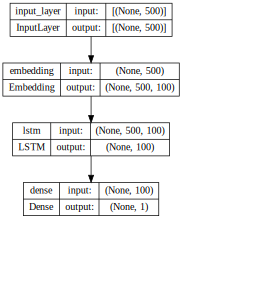

In [ ]:
SVG(vis_utils.model_to_dot(model4, show_shapes=True, show_layer_names=True, dpi=100).create(prog='dot', format='svg'))

In [ ]:
history4 = model4.fit(train_x, train_y, epochs=6, batch_size=len(train_data), validation_data=(validation_x, validation_y))

Epoch 1/6
1/1 [==============================] - 27s 27s/step - loss: 0.6935 - accuracy: 0.4790 - val_loss: 0.6928 - val_accuracy: 0.5110
Epoch 2/6
1/1 [==============================] - 8s 8s/step - loss: 0.6928 - accuracy: 0.5157 - val_loss: 0.6922 - val_accuracy: 0.5635
Epoch 3/6
1/1 [==============================] - 8s 8s/step - loss: 0.6920 - accuracy: 0.5783 - val_loss: 0.6915 - val_accuracy: 0.5985
Epoch 4/6
1/1 [==============================] - 8s 8s/step - loss: 0.6912 - accuracy: 0.6126 - val_loss: 0.6907 - val_accuracy: 0.6030
Epoch 5/6
1/1 [==============================] - 8s 8s/step - loss: 0.6901 - accuracy: 0.6217 - val_loss: 0.6896 - val_accuracy: 0.6285
Epoch 6/6
1/1 [==============================] - 8s 8s/step - loss: 0.6888 - accuracy: 0.6477 - val_loss: 0.6882 - val_accuracy: 0.6550


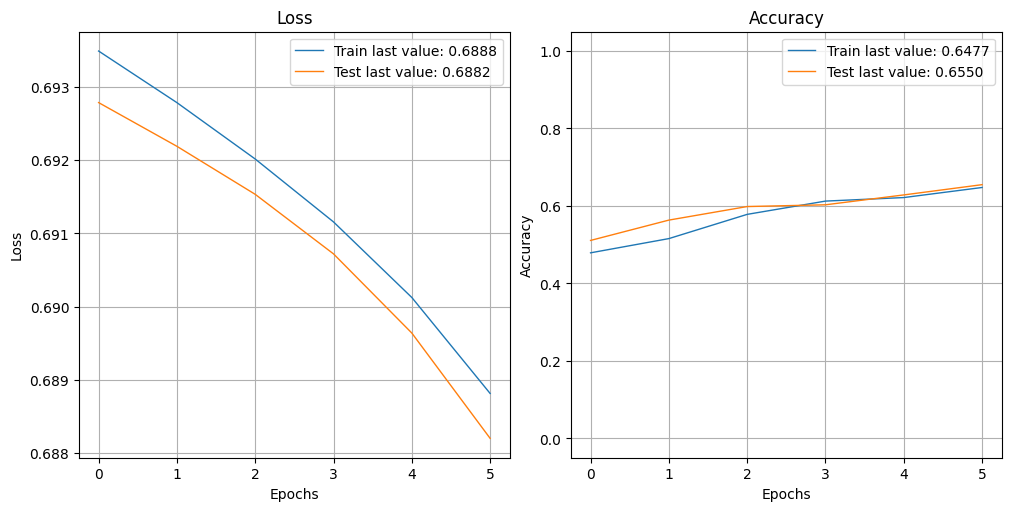

In [ ]:
plot_history(history4.history, path="standard4.png")
plt.show()

In [ ]:
results4 = model4.evaluate(padded_test_data, test_labels)
print('test_loss:', results4[0], 'test_accuracy:', results4[1])

782/782 [==============================] - 23s 27ms/step - loss: 0.6880 - accuracy: 0.6456
test_loss: 0.6879885196685791 test_accuracy: 0.6456400156021118


In [ ]:
def create_model5():
  return Sequential([
    Input((MAX_LENGTH,), dtype="int32", name="input_layer"),
    Embedding(VOCAB_SIZE, EMBED_SIZE, mask_zero=True),
    LSTM(100),
    Dense(1, activation="sigmoid")
  ])

In [ ]:
use_tpu = True
if use_tpu:

  # Create model on TPU:
  with strategy.scope():
    model5 = create_model5()
    optimizer5 = tf.keras.optimizers.Adam()
    model5.compile(optimizer=optimizer5, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model5 = create_model5()
  model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

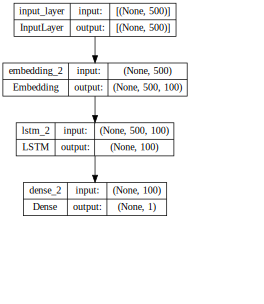

In [ ]:
SVG(vis_utils.model_to_dot(model5, show_shapes=True, show_layer_names=True, dpi=100).create(prog='dot', format='svg'))

In [ ]:
history5 = model5.fit(train_x, train_y, epochs=6, batch_size=32, validation_data=(validation_x, validation_y))

Epoch 1/6
719/719 [==============================] - 65s 76ms/step - loss: 0.4771 - accuracy: 0.7750 - val_loss: 0.5258 - val_accuracy: 0.7400
Epoch 2/6
719/719 [==============================] - 49s 68ms/step - loss: 0.3349 - accuracy: 0.8615 - val_loss: 0.3217 - val_accuracy: 0.8685
Epoch 3/6
719/719 [==============================] - 49s 68ms/step - loss: 0.2329 - accuracy: 0.9126 - val_loss: 0.2996 - val_accuracy: 0.8780
Epoch 4/6
719/719 [==============================] - 49s 69ms/step - loss: 0.1777 - accuracy: 0.9341 - val_loss: 0.3770 - val_accuracy: 0.8610
Epoch 5/6
719/719 [==============================] - 50s 69ms/step - loss: 0.1384 - accuracy: 0.9497 - val_loss: 0.3434 - val_accuracy: 0.8680
Epoch 6/6
719/719 [==============================] - 50s 69ms/step - loss: 0.1049 - accuracy: 0.9639 - val_loss: 0.3865 - val_accuracy: 0.8770


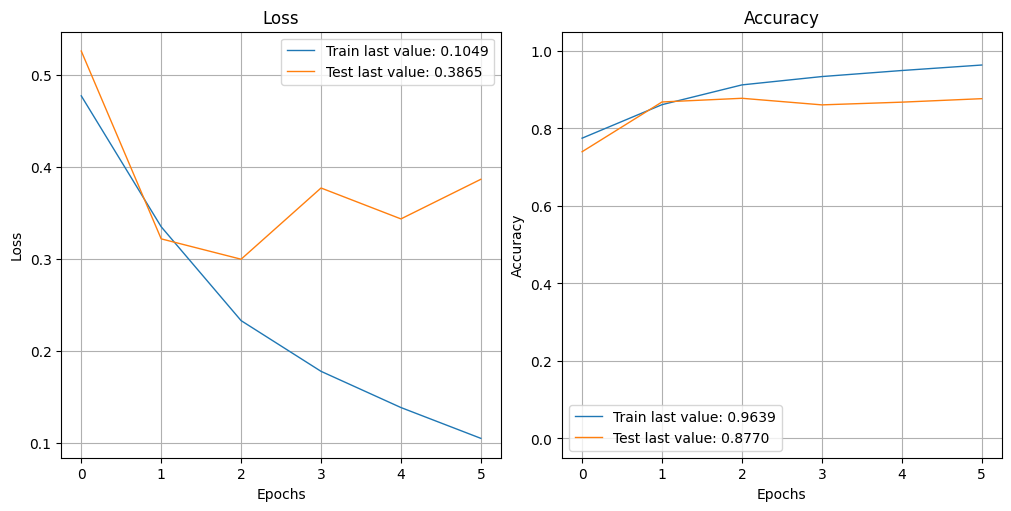

In [ ]:
plot_history(history5.history, path="standard5.png")
plt.show()

In [ ]:
results5 = model5.evaluate(padded_test_data, test_labels)
print('test_loss:', results5[0], 'test_accuracy:', results5[1])

782/782 [==============================] - 22s 27ms/step - loss: 0.4342 - accuracy: 0.8619
test_loss: 0.434171199798584 test_accuracy: 0.8618800044059753
